In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = "../app/data_pipeline"

features = pd.read_csv(f"{BASE}/features_train.csv")
print(features.shape)
features.head()

(266500, 42)


,target_date,warehouse_id,store_id,sku_id,region,actual_order_qty,lag_1,lag_2,lag_4,lag_8,...,back_to_school,avg_temp_c_ma4,cdd_ma4,hdd_ma4,precip_mm_ma4,himart_sales_index_ma4,holiday_index_ma4,marketing_score_ma4,y,split
0,2016-02-29,1,1,AC-CAR-16P-2024,본사창고,60,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,train
1,2016-03-07,1,1,AC-CAR-16P-2024,본사창고,0,60.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,2016-03-14,1,1,AC-CAR-16P-2024,본사창고,0,0.0,60.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,2016-03-21,1,1,AC-CAR-16P-2024,본사창고,0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
4,2016-03-28,1,1,AC-CAR-16P-2024,본사창고,0,0.0,0.0,60.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [5]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matyplotlib -rf

Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [6]:
plt.rc('font', family='NanumBarunGothic')

# EDA
## 1. 타겟 분포 확인

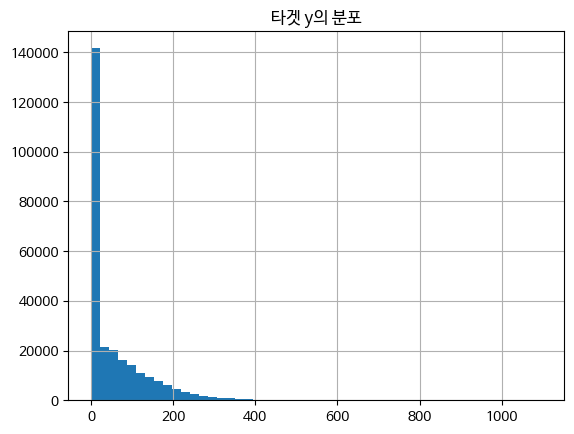

In [7]:
features["y"].hist(bins=50)
plt.title("타겟 y의 분포")
plt.show()

## 2. 기본 통계

In [9]:
features["y"].describe()

count    266500.000000
mean         57.265831
std          91.376801
min           0.000000
25%           0.000000
50%           0.000000
75%          89.000000
max        1098.000000
Name: y, dtype: float64

median(50%) = 0, 75% = 89, max = 1098  
-> 거의 절반 이상의 주차가 판매 0. 나머지는 오른쪽으로 긴 꼬리가 있는 heavy right tail 분포  
: 0이 엄청 많고 일부 SKU가 크게 팔리는 구조. 전형적인 리테일/재고 데이터 모습  
: MAE 기준으로 보면 큰 수요가 있는 주차가 훨씬 더 영향을 많이 줌

## 3. 카테고리/sku별 판매량

In [23]:
features.columns.tolist()

['target_date',
 'warehouse_id',
 'store_id',
 'sku_id',
 'region',
 'actual_order_qty',
 'lag_1',
 'lag_2',
 'lag_4',
 'lag_8',
 'lag_12',
 'ma_4',
 'ma_8',
 'ma_12',
 'share_norm',
 'promo_flag',
 'year',
 'weekofyear',
 'month',
 'sin_week',
 'cos_week',
 'avg_temp_c',
 'cdd',
 'hdd',
 'precip_mm',
 'heat_wave',
 'cold_wave',
 'himart_sales_krw',
 'himart_sales_index',
 'holiday_index',
 'marketing_score',
 'seasonal_peak',
 'back_to_school',
 'avg_temp_c_ma4',
 'cdd_ma4',
 'hdd_ma4',
 'precip_mm_ma4',
 'himart_sales_index_ma4',
 'holiday_index_ma4',
 'marketing_score_ma4',
 'y',
 'split']

In [22]:
import pandas as pd
BASE = "../app/data_pipeline"
sku = pd.read_csv(f"{BASE}/sku_catalog.csv")

sku = sku[['sku_id', 'cat_low']] 

features_merged = features.merge(sku, on='sku_id', how='left')
features_merged.groupby("cat_low")["y"].sum().sort_values(ascending=False).head(20)


cat_low
데스크탑     1247196.0
믹서기      1194356.0
스마트워치    1193706.0
전자레인지    1089324.0
식기세척기    1036365.0
토스터기      986660.0
커피머신      986093.0
노트북       831330.0
냉장고       830169.0
공기청정기     829390.0
에어컨       828967.0
오븐        728422.0
라우터       673316.0
프린터       571376.0
세탁기       519061.0
스마트폰      468059.0
모니터       363387.0
건조기       312677.0
TV        311730.0
청소기       259760.0
Name: y, dtype: float64

어떤 카테고리/상품이 수요예측에서 중요한지.  

## 4. 날짜·주차별 패턴

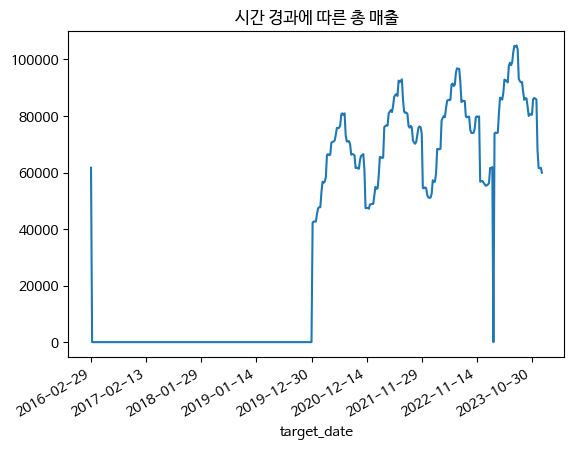

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
features.groupby("target_date")["y"].sum().plot(ax=ax)
plt.title("시간 경과에 따른 총 매출")

fig.autofmt_xdate() 
plt.show()


연도별로 계절 패턴이 보임  
-> 주간 수요예측 모델이 시즌성을 잘 잡아야함

## 5. 외부 요인 영향

In [13]:
cols = ["avg_temp_c", "holiday_index", "promo_flag"]  
features[cols + ["y"]].corr()


,avg_temp_c,holiday_index,promo_flag,y
avg_temp_c,1.000000,0.032033,0.385128,0.462669
holiday_index,0.032033,1.000000,0.172706,0.113058
promo_flag,0.385128,0.172706,1.000000,0.683901
y,0.462669,0.113058,0.683901,1.000000


프로모션, 기온은 수요에 큰 영향 줌. -> 피쳐로 유지  
완벽히 선형 관계는 아님. -> 트리계열 모델 사용해서 이런 패턴 잡아주기 

## 6.타깃 로그 변환 분포 확인

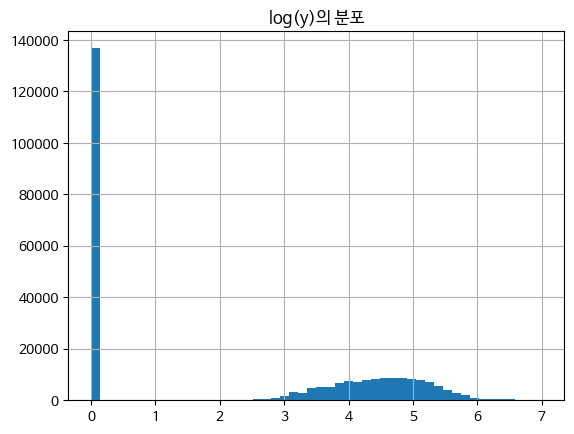

In [24]:
features["log_y"] = np.log1p(features["y"])
features["log_y"].hist(bins=50)
plt.title("log(y)의 분포")
plt.show()

0인 값이 많음 == 판매가 0인 주차가 많음.  
로그를 써서 큰 값 쪽 꼬리는 완화했지만 0값에 대해서는 따로 접근해야할수도 있음 

## 7. Lag Feature 상관분석  
Lag : 시차 변수. 과거 시점의 값을 그대로 가져와서 새로운 변수로 사용하는 것.

In [25]:
lag_cols = ["lag_1","lag_2","lag_4","lag_8","lag_12"]
features[lag_cols + ["y"]].corr()


,lag_1,lag_2,lag_4,lag_8,lag_12,y
lag_1,1.000000,0.982528,0.968793,0.941425,0.913102,0.982557
lag_2,0.982528,1.000000,0.975657,0.948364,0.920790,0.975751
lag_4,0.968793,0.975657,1.000000,0.963253,0.936858,0.962365
lag_8,0.941425,0.948364,0.963253,1.000000,0.965848,0.934616
lag_12,0.913102,0.920790,0.936858,0.965848,1.000000,0.905428
y,0.982557,0.975751,0.962365,0.934616,0.905428,1.000000


## 8. MA Feature 상관분석  
MA : 이동 평균. 일정 기간 동안의 평균값을 굴러가며 계산하는 것.

In [26]:
ma_cols = ["ma_4","ma_8","ma_12"]
features[ma_cols + ["y"]].corr()

,ma_4,ma_8,ma_12,y
ma_4,1.000000,0.994572,0.986542,0.978779
ma_8,0.994572,1.000000,0.996713,0.969684
ma_12,0.986542,0.996713,1.000000,0.959952
y,0.978779,0.969684,0.959952,1.000000


lag_* 와 y 상관이 0.93~0.98 수준, ma_*도 비슷하게 높음  
-> 바로 전/이전 주 수요가 현재 주 수요를 거의 직접적으로 설명.

## 9. 외부 요인 히트맵

In [31]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


<Axes: >

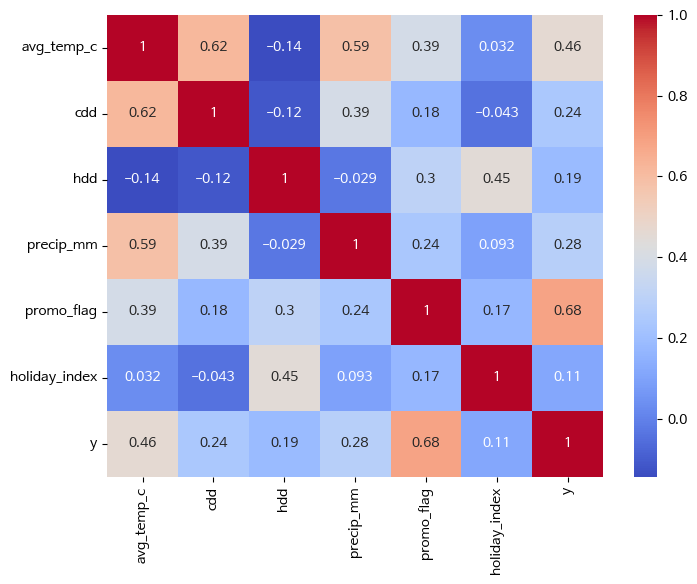

In [34]:
import seaborn as sns
plt.figure(figsize=(8,6))
cols = ["avg_temp_c","cdd","hdd","precip_mm","promo_flag","holiday_index"]
sns.heatmap(features[cols + ["y"]].corr(), annot=True, cmap="coolwarm")

## 10. SKU Sales profile

In [28]:
features.groupby("sku_id")["y"].sum().sort_values(ascending=False).head(20)

sku_id
MIX-CUI-HAND-2024         1194356.0
WAT-APL-AW-41-2024         598536.0
WAT-SAM-GAL-45-2024        595170.0
TOA-BRN-2S-2024            493330.0
TOA-PHI-2S-2024            493330.0
DES-HP-STD-2024            428326.0
MW-SAM-30L-2024            417011.0
DW-SAM-12P-2024            414531.0
DES-LEN-THINK-2024         413136.0
DES-SAM-STD-2024           405734.0
MW-LG-25L-2024             364845.0
DW-LG-12P-2024             362718.0
COF-BRV-SEMI-2024          332888.0
AIR-LG-PURI-58-2024        331827.0
AC-LG-STAND-18P-2024       331679.0
COF-NES-CAPS-2024          329831.0
OV-LG-70L-2024             327825.0
COF-DEL-AUTO-2024          323374.0
NBK-SAM-GALAXY-15-2024     281452.0
NBK-LG-GRAM-16-2024        275897.0
Name: y, dtype: float64

## 11. Feature Importance
데이터 일부만 이용해서 대략적인 feature 영향도 먼저 확인  
LightGBM로 미리 확인

In [36]:
from lightgbm import LGBMRegressor
# 1) 학습용 데이터만 선택
train = features[features["split"] == "train"].copy()

# 2) 타겟
y = train["y"]

# 3) 모델에 안 쓸 ID/날짜/타겟 컬럼은 제외
ignore = [
    "warehouse_id", "store_id", "sku_id", "region",
    "target_date", "split", "y",  # 필요 없다면 log_y도 여기 넣기
]

X = train.drop(columns=ignore, errors="ignore")

# 4) 혹시 모를 non-numeric 컬럼 한 번 더 필터링
numeric_cols = X.select_dtypes(include=["number", "bool"]).columns
X = X[numeric_cols]

from lightgbm import LGBMRegressor

model = LGBMRegressor(random_state=42)
model.fit(X, y)

importances = (
    pd.Series(model.feature_importances_, index=X.columns)
      .sort_values(ascending=False)
)
importances.head(20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4150
[LightGBM] [Info] Number of data points in the train set: 266500, number of used features: 36
[LightGBM] [Info] Start training from score 57.265831


actual_order_qty          1305
lag_12                     162
lag_4                      137
lag_1                      130
lag_2                      126
lag_8                      122
marketing_score_ma4         99
marketing_score             92
precip_mm                   90
weekofyear                  88
precip_mm_ma4               84
avg_temp_c_ma4              71
avg_temp_c                  69
sin_week                    63
cos_week                    44
ma_4                        43
himart_sales_index_ma4      37
ma_12                       30
share_norm                  28
himart_sales_krw            27
dtype: int32

In [37]:
train = features[features["split"] == "train"].copy()
test  = features[features["split"] == "test"].copy()   # 또는 holdout 기간

ignore = ["warehouse_id","store_id","sku_id","region","target_date","split","y"]
X_train = train.drop(columns=ignore, errors="ignore")
X_test  = test.drop(columns=ignore, errors="ignore")

num_cols = X_train.select_dtypes(include=["number","bool"]).columns
X_train = X_train[num_cols]
X_test  = X_test[num_cols]

y_train = train["y"]
y_test  = test["y"]


In [38]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(X_train, y_train)

pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, pred)

print("Baseline MAE:", mae)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4150
[LightGBM] [Info] Number of data points in the train set: 266500, number of used features: 36
[LightGBM] [Info] Start training from score 57.265831


ValueError: Input data must be 2 dimensional and non empty.

In [40]:
importances = (
    pd.Series(model.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
)
importances.head(30)


actual_order_qty          3354
lag_1                     1857
lag_12                     833
lag_2                      811
lag_8                      755
lag_4                      735
precip_mm                  628
log_y                      585
marketing_score_ma4        530
precip_mm_ma4              514
marketing_score            464
avg_temp_c                 379
weekofyear                 376
avg_temp_c_ma4             353
sin_week                   333
ma_4                       327
cos_week                   292
share_norm                 268
ma_12                      209
himart_sales_index_ma4     175
himart_sales_krw           155
cdd                        153
ma_8                       150
hdd_ma4                    145
hdd                        143
cdd_ma4                    126
year                       114
month                       63
himart_sales_index          44
seasonal_peak               33
dtype: int32

In [41]:
y_train_log = np.log1p(y_train)
model_log = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
model_log.fit(X_train, y_train_log)

pred_log = model_log.predict(X_test)
pred_log_to_y = np.expm1(pred_log)

mae_log = mean_absolute_error(y_test, pred_log_to_y)
print("MAE (log target):", mae_log)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4150
[LightGBM] [Info] Number of data points in the train set: 266500, number of used features: 36
[LightGBM] [Info] Start training from score 2.185430


ValueError: Input data must be 2 dimensional and non empty.